# Speaker Similarity

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/diarization-speaker-similarity](https://github.com/huseinzol05/malaya-speech/tree/master/example/diarization-speaker-similarity).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages. Pretrained models trained on multilanguages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

### What is Speaker Diarization

In one audio sample, we want to know the timestamp for multiple speakers.

In [1]:
from malaya_speech import Pipeline
import malaya_speech
import numpy as np
import matplotlib.pyplot as plt

### load Speaker Vector

So to know speakers similarity, we can use speaker vector, just load using `malaya_speech.speaker_vector.deep_model`. Read more about malaya-speech Speaker Vector at https://malaya-speech.readthedocs.io/en/latest/load-speaker-vector.html

We are going to compare `conformer-base` and `vggvox-v2`.

In [6]:
model_conformer = malaya_speech.speaker_vector.deep_model('conformer-base')
model_vggvox2 = malaya_speech.speaker_vector.deep_model('vggvox-v2')

### Load audio sample

In [3]:
y, sr = malaya_speech.load('speech/video/The-Singaporean-White-Boy.wav')
len(y), sr

(1634237, 16000)

In [4]:
# just going to take 60 seconds
y = y[:sr * 60]

This audio extracted from https://www.youtube.com/watch?v=HylaY5e1awo&t=2s

In [27]:
# import IPython.display as ipd

# ipd.Audio(y, rate = sr)

### Load VAD

We need to use VAD module to know which parts of the audio sample are speaker activities, read more about VAD at https://malaya-speech.readthedocs.io/en/latest/load-vad.html

In [26]:
vad = malaya_speech.vad.deep_model(model = 'vggvox-v2')

In [19]:
frames = list(malaya_speech.utils.generator.frames(y, 30, sr))

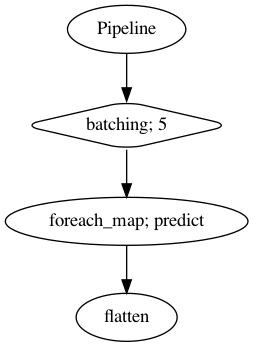

In [20]:
p = Pipeline()
pipeline = (
    p.batching(5)
    .foreach_map(vad.predict)
    .flatten()
)
p.visualize()

In [21]:
%%time

result = p(frames)
result.keys()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=480
  n_fft, y.shape[-1]


CPU times: user 1min 1s, sys: 39.6 s, total: 1min 41s
Wall time: 21.9 s


dict_keys(['batching', 'predict', 'flatten'])

In [24]:
frames_vad = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]
grouped_vad = malaya_speech.utils.group.group_frames(frames_vad)
grouped_vad = malaya_speech.utils.group.group_frames_threshold(grouped_vad, threshold_to_stop = 0.3)

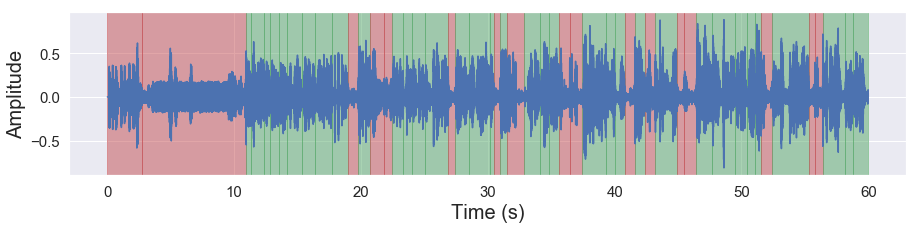

In [25]:
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, figsize = (15, 3))

### Speaker Similarity

Simplest technique, calculate similarity,

```python
def speaker_similarity(
    vad_results,
    speaker_vector,
    similarity_threshold: float = 0.8,
    norm_function: Callable = None,
    return_embedding: bool = False,
):
    """
    Speaker diarization using L2-Norm similarity.

    Parameters
    ----------
    vad_results: List[Tuple[Frame, label]]
        results from VAD.
    speaker_vector: callable
        speaker vector object.
    speaker_change_results: List[Tuple[FRAME, float]], optional (default=None)
        results from speaker change module, must in float result.
    similarity_threshold: float, optional (default=0.8)
        if current voice activity sample similar at least 80%, we assumed it is from the same speaker.
    norm_function: Callable, optional(default=None)
        normalize function for speaker vectors.
    speaker_change_threshold: float, optional (default=0.5)
        in one voice activity sample can be more than one speaker, split it using this threshold.

    Returns
    -------
    result : List[Tuple[Frame, label]]
    """
```

In [28]:
result_diarization_conformer = malaya_speech.diarization.speaker_similarity(grouped_vad, model_conformer)
result_diarization_conformer[:5]

[(<malaya_speech.model.frame.Frame at 0x17e171050>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x19566aa10>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x19566a210>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x19566af10>, 'speaker 1'),
 (<malaya_speech.model.frame.Frame at 0x18f002090>, 'speaker 2')]

In [29]:
result_diarization_vggvox2 = malaya_speech.diarization.speaker_similarity(grouped_vad, model_vggvox2)
result_diarization_vggvox2[:5]

[(<malaya_speech.model.frame.Frame at 0x17e171050>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x19566aa10>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x19566a210>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x19566af10>, 'speaker 1'),
 (<malaya_speech.model.frame.Frame at 0x18f002090>, 'speaker 1')]

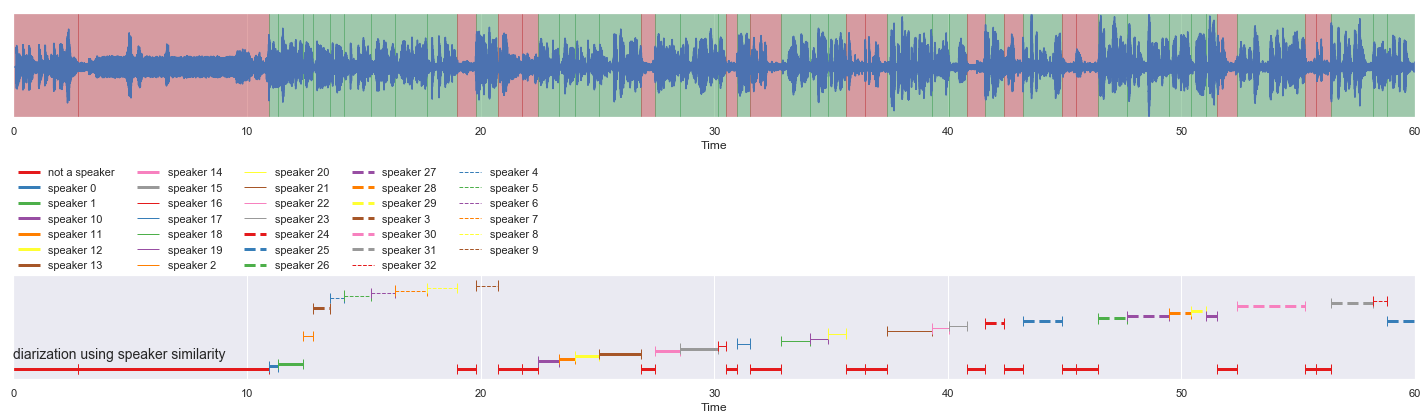

In [30]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_conformer, 
                                                      'diarization using speaker similarity', ax = ax[1],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

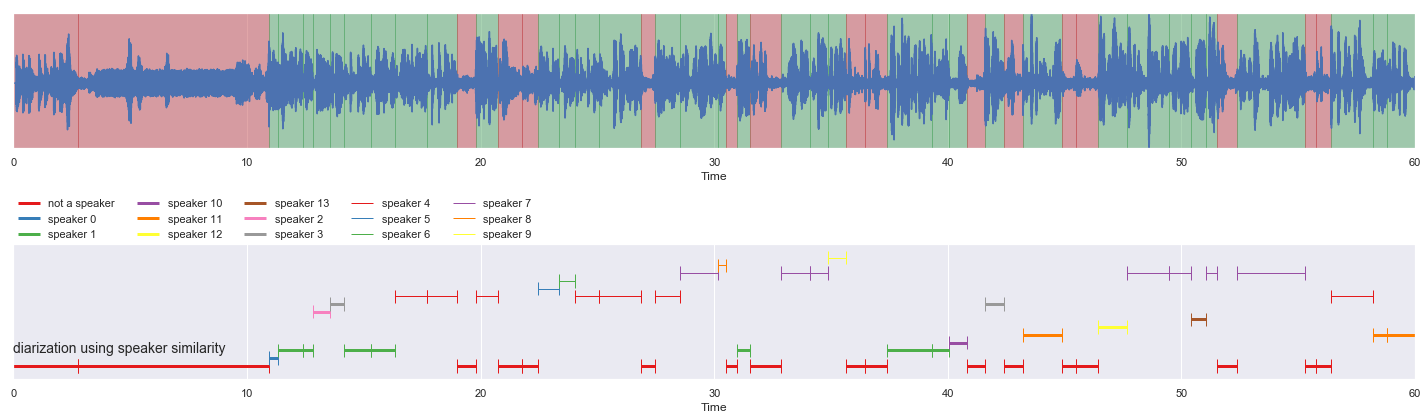

In [31]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_vggvox2, 
                                                      'diarization using speaker similarity', ax = ax[1],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

Problem with speaker similarity, speaker vector models are not really consistent, definition of similarity is ambigious among models, 90% similarity from model A might not be same as model B.